**SENTIMENT ANALYSIS ON PAPER REVIEWS USING MACHINE LEARNING AND DEEP LEARNING MODELS**

**INSTALLING THE REQUIRED LIBRARIES**

In [1]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install deep-translator
!pip install nltk
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.2 MB/s eta 0:00:00


**IMPORTING THE REQUIRED LIBRARIES**

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import nltk
from deep_translator import GoogleTranslator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from deep_translator import GoogleTranslator


from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import gzip
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping


**LOADING DATASET AND FLATTENING IT**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Load the JSON file
json_path = "/content/drive/MyDrive/DS_Project/reviews.json"
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Flatten the nested structure into a DataFrame
flattened_reviews = []

for paper in data['paper']:
    paper_id = paper.get('id')
    preliminary_decision = paper.get('preliminary_decision')

    for review in paper['review']:
        flattened_review = {
            'paper_id': paper_id,
            'preliminary_decision': preliminary_decision,
            'review_id': review.get('id'),
            'confidence': review.get('confidence'),
            'evaluation': review.get('evaluation'),
            'orientation': review.get('orientation'),
            'language': review.get('lan'),
            'remarks': review.get('remarks'),
            'text': review.get('text'),
            'timespan': review.get('timespan')
        }
        flattened_reviews.append(flattened_review)

#  Create the DataFrame
df = pd.DataFrame(flattened_reviews)
print("Flattened DataFrame created. Shape:", df.shape)
print(df.head(2))

Mounted at /content/drive
Flattened DataFrame created. Shape: (405, 10)
   paper_id preliminary_decision  review_id confidence evaluation orientation  \
0         1               accept          1          4          1           0   
1         1               accept          2          4          1           1   

  language remarks                                               text  \
0       es          - El artículo aborda un problema contingente y...   
1       es          El artículo presenta recomendaciones prácticas...   

     timespan  
0  2010-07-05  
1  2010-07-05  



**DATASET INFORMATION AND CLASS DISTRIBUTION**

In [4]:
print("Language distribution (UnBalanced Dataset):")
print(df['language'].value_counts())


df.info()

Language distribution (UnBalanced Dataset):
language
es    388
en     17
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   paper_id              405 non-null    int64 
 1   preliminary_decision  405 non-null    object
 2   review_id             405 non-null    int64 
 3   confidence            403 non-null    object
 4   evaluation            405 non-null    object
 5   orientation           405 non-null    object
 6   language              405 non-null    object
 7   remarks               405 non-null    object
 8   text                  405 non-null    object
 9   timespan              405 non-null    object
dtypes: int64(2), object(8)
memory usage: 31.8+ KB


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-5-252681383.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='language', palette='Set2')


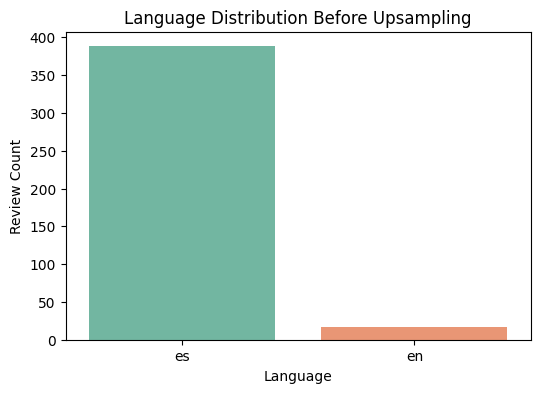

In [5]:
# Downloads for NLTK
nltk.download('punkt')
nltk.download('stopwords')


# Plot bar chart
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='language', palette='Set2')
plt.title('Language Distribution Before Upsampling')
plt.xlabel('Language')
plt.ylabel('Review Count')
plt.show()


If left unbalanced, a model might just predict "es" for everything and still achieve high accuracy.

After balancing, the model gets enough training signals from both classes.

Helps achieve better precision, recall, and fairness in classification

In [6]:
# STEP : Check original language distribution
print("Original language counts:\n", df['language'].value_counts())

# STEP : Upsample English reviews to match Spanish
df_es = df[df['language'] == 'es']
df_en = df[df['language'] == 'en']


# Import resample from sklearn.utils
from sklearn.utils import resample
df_en_upsampled = resample(
    df_en,
    replace=True,
    n_samples=len(df_es),  # match Spanish count
    random_state=42
)

# STEP : Combine and shuffle
df_balanced = pd.concat([df_es, df_en_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# STEP : Confirm new balanced distribution
print("\nBalanced language counts:\n", df_balanced['language'].value_counts())
df_balanced.head()


Original language counts:
 language
es    388
en     17
Name: count, dtype: int64

Balanced language counts:
 language
en    388
es    388
Name: count, dtype: int64


,paper_id,preliminary_decision,review_id,confidence,evaluation,orientation,language,remarks,text,timespan
0,8,accept,2,4,2,1,en,,This manuscript addresses an interesting solut...,2010-07-05
1,69,accept,1,4,0,-1,en,,This is a developed application to support inf...,2013-07-05
2,140,reject,1,4,-2,-2,es,,El artículo realiza una reflexión sobre el est...,2015-07-05
3,19,accept,1,4,2,1,en,,"This paper is very interesting, I like the ide...",2010-07-05
4,159,accept,1,4,0,0,es,"En caso que el trabajo sea aceptado, se recomi...",El artículo presenta una evaluación de técnica...,2015-07-05


Handling Class Imbalance with Upsampling
In the original dataset, there is a significant class imbalance in the language feature:

Spanish (es) reviews: 388
English (en) reviews: 17
This imbalance can lead to biased model predictions where the model favors the majority class (es) and underperforms on the minority class (en). To address this, we apply upsampling to the minority class.

Upsampling involves randomly replicating examples from the minority class until both classes are equally represented. This ensures that the model receives a balanced number of examples from each class during training.

We have applied upsampling using the resample() function from sklearn.utils:

/tmp/ipython-input-7-883266213.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='language', palette='Set2')


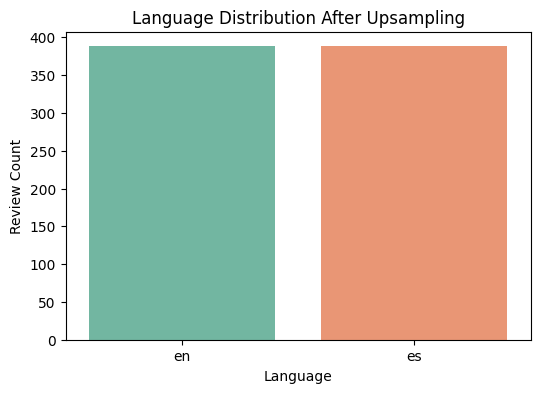

In [7]:
# Plot bar chart
plt.figure(figsize=(6,4))
sns.countplot(data=df_balanced, x='language', palette='Set2')
plt.title('Language Distribution After Upsampling')
plt.xlabel('Language')
plt.ylabel('Review Count')
plt.show()

Original language distribution:
language
es    388
en     17
Name: count, dtype: int64


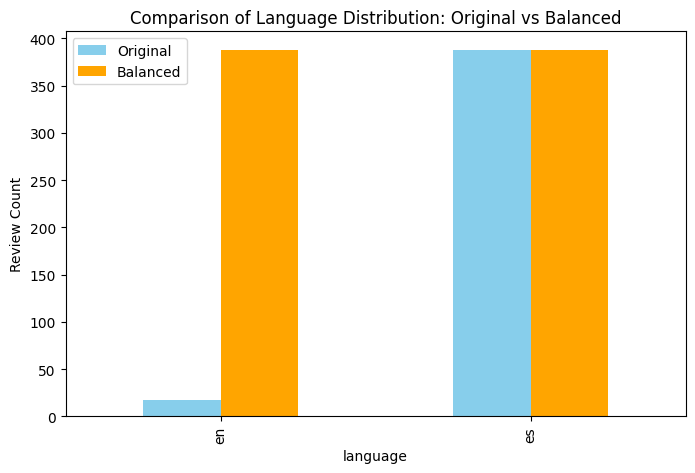

In [8]:
# Original language distribution
print("Original language distribution:")
print(df['language'].value_counts())

# Plot both side by side
lang_counts_original = df['language'].value_counts()
lang_counts_balanced = df_balanced['language'].value_counts()

# Combine into one DataFrame
lang_compare = pd.DataFrame({
    'Original': lang_counts_original,
    'Balanced': lang_counts_balanced
})

lang_compare.plot(kind='bar', figsize=(8,5), color=['skyblue', 'orange'])
plt.title('Comparison of Language Distribution: Original vs Balanced')
plt.ylabel('Review Count')
plt.show()